In [1]:
"""
Goals:
- understand cross entropy method
- understand main challenges in using it for IS
- understand challenges in doing active learning
Plan:
- fit a network to some dataset 
- fit it again using some other method
""";

In [2]:
%matplotlib inline
import collections
import matplotlib.pyplot as plt
import numpy as np

In [30]:
def identity(x):
    return x

def gaussian_pdf(x, mu=0, sigma=1):
    return 1/np.sqrt(2 * sigma ** 2 * np.pi) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def logistic(x):
    return 1 / (1 + np.exp(-x))

def gen_1d_data(gen, xmin, xmax, num_samples):
    x = np.linspace(xmin, xmax, num_samples)
    return (x.reshape(-1,1), gen(x).reshape(-1,1))    

def init_toy_data(batch_size, input_dim, output_dim):
    np.random.seed(1)
    X = 10 * np.random.randn(batch_size, input_dim)
    y = np.random.randn(batch_size, output_dim)
    return X, y

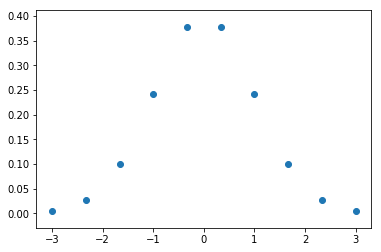

In [15]:
num_samples = 10
x, y = gen_1d_data(gaussian_pdf, -3, 3, num_samples)
plt.scatter(x,y)

In [44]:
class basic_nnet(object):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.initialize_params()
        
    def initialize_params(self):
        # input to hidden 
        w_1 = np.random.randn(self.input_dim, self.hidden_dim)
        b_1 = np.zeros((1, self.hidden_dim)) + .01
        
        # hidden to hidden
        w_2 = np.random.randn(self.hidden_dim, self.hidden_dim)
        b_2 = np.zeros((1, self.hidden_dim)) + .01
        
        # hidden to output
        w_3 = np.random.randn(self.hidden_dim, self.output_dim)
        b_3 = np.zeros((1, self.output_dim))
        
        self.params = {'w_1': w_1, 'b_1': b_1, 
                       'w_2': w_2, 'b_2': b_2,
                       'w_3': w_3, 'b_3': b_3}
        
    def loss(self, X, y=None):
        w_1, b_1 = self.params['w_1'], self.params['b_1'] 
        w_2, b_2 = self.params['w_2'], self.params['b_2']
        w_3, b_3 = self.params['w_3'], self.params['b_3']
        
        # input to hidden
        h_1 = np.maximum(0, np.dot(X, w_1) + b_1)
        h_2 = np.maximum(0, np.dot(h_1, w_2) + b_2)
        
        # hidden to output
        scores = np.dot(h_2, w_3) + b_3
        
        # if y not provided, then just return scores
        if y is None:
            return scores
        
        # loss 
        loss = .5 * np.sum((scores - y) ** 2)
        
        # grads
        dloss_dscores = (scores - y)
        dscores_db_3 = np.sum(dloss_dscores, axis=0, keepdims=True)
        dscores_dw_3 = np.dot(h_2.T, dloss_dscores)
        dscores_dh2 = np.dot(dloss_dscores, w_3.T)
        
        dh_2_dz_2 = dscores_dh2[:]
        dh_2_dz_2[h_2 <= 0] = 0
        dz_2_db_2 = np.sum(dh_2_dz_2, axis=0, keepdims=True)
        dz_2_dw_2 = np.dot(h_1.T, dh_2_dz_2)
        dz_2_dh_1 = np.dot(dh_2_dz_2, w_2.T)
        
        dh_1_dz_1 = dz_2_dh_1[:]
        dh_1_dz_1[h_1 <= 0] = 0
        dz_1_db_1 = np.sum(dh_1_dz_1, axis=0, keepdims=True)
        dz_1_dw_1 = np.dot(X.T, dh_1_dz_1)
        
        grads = {}
        grads['w_1'] = dz_1_dw_1
        grads['b_1'] = dz_1_db_1
        grads['w_2'] = dz_2_dw_2
        grads['b_2'] = dz_2_db_2
        grads['w_3'] = dscores_dw_3
        grads['b_3'] = dscores_db_3
        
        return loss, grads
    
    def train(self, X, y, lr=0.001, batch_size=10, num_epochs=10, lr_decay=.999, verbose=True):
        
        # train for epochs
        for epoch in range(num_epochs):
            
            # determine batches
            num_batches = int(len(X) / batch_size)
            if num_batches < len(X) / batch_size:
                num_batches += 1
            
            losses = []
            for bidx in range(num_batches):
                
                # compute loss and grads on this batch
                s = bidx * batch_size
                e = s + batch_size
                loss, grads = self.loss(X[s:e], y[s:e])
                losses.append(loss)
                
                # perform gradient descent update
                for k in self.params.keys():
                    self.params[k] -= lr * grads[k]
            
            # lr update
            lr *= lr_decay
            
            # how's it goin?
            if verbose and epoch % 100 == 0:
                print('epoch: {} / {}\t loss: {}'.format(epoch, num_epochs, np.mean(losses)))
                

In [17]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension
    return grad

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [18]:
input_dim, hidden_dim, output_dim, batch_size = 1, 2, 1, 2
net = basic_nnet(input_dim, hidden_dim, output_dim)
X, y = init_toy_data(batch_size, input_dim, output_dim)
loss, grads = net.loss(X, y)

# these should all be less than 1e-8 or so
for param_name in grads.keys():
    
    f = lambda W: net.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b_1 max relative error: 6.401469e-10
b_2 max relative error: 1.344131e-10
w_1 max relative error: 5.726133e-12
w_2 max relative error: 1.749904e-11
w_3 max relative error: 3.472208e-12
b_3 max relative error: 2.122496e-10


In [48]:
num_samples = 1000
input_dim, hidden_dim, output_dim, batch_size = 1, 16, 1, 200
net = basic_nnet(input_dim, hidden_dim, output_dim)
X, y = gen_1d_data(logistic, -3, 3, num_samples)

In [54]:
net.train(X, y, lr=.001, num_epochs=1000, lr_decay=.995, verbose=True)

epoch: 0 / 1000	 loss: 0.000354581948040594
epoch: 100 / 1000	 loss: 0.0006510606897542087
epoch: 200 / 1000	 loss: 0.0006191346823571936
epoch: 300 / 1000	 loss: 0.0005842560835957554
epoch: 400 / 1000	 loss: 0.0005584043479705025
epoch: 500 / 1000	 loss: 0.0005438264347901942
epoch: 600 / 1000	 loss: 0.0005334860469525473
epoch: 700 / 1000	 loss: 0.0005281317793502976
epoch: 800 / 1000	 loss: 0.0005247175118308653
epoch: 900 / 1000	 loss: 0.0005227208728861159


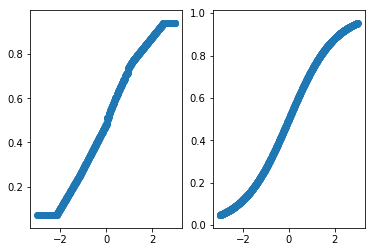

In [55]:
x = np.linspace(-3,3,num_samples).reshape(-1,1)
y_pred = net.loss(x)
plt.subplot('121')
plt.scatter(x, y_pred)
plt.subplot('122')
plt.scatter(x, y)

In [ ]:
"""
Ok it kinda of works now what?
- see how many samples to get good loss?
- 
"""